In [ ]:
! pip install torch-summary

In [ ]:
# note, this is using a different verison of torchsummary than the labs
# https://pypi.org/project/torch-summary/

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
from torchsummary import summary
import time
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import librosa.display
import math
import os

IRMAS_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/IRMAS-TrainingData/"
JSON_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/json_files/"
filename = "irmas_data_mfcc13_hop_length256_n_fft2048.json"

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Define a PyTorch dataset to load json file

TODO: consider pulling directly from wav files and convert to MFCCs as a transform (might take too long)

In [ ]:

class IRMASDataset(Dataset):
  def __init__(self, JSON_PATH, filename, transform=None):
    with open(JSON_PATH + filename, "r") as f:
      self.irmas_data = json.load(f)
    self.metadata = self.irmas_data.pop('metadata') 
    self.instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax",
    "tru", "vio", "voi"]
    self.encoder = LabelEncoder()
    self.encoder.fit(self.instruments)

  def __len__(self):
    return len(self.irmas_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = np.array(idx.tolist())

    mfccs = np.array(self.irmas_data[str(idx)]['mfccs'])[np.newaxis,...]

    primary_instrument = self.encoder.transform(
      [np.array(self.irmas_data[str(idx)]['primary_instrument'])]
    )
    sample = {'mfccs': mfccs, 'instrument': primary_instrument, 'metadata': self.metadata}
    return sample


# Prepare Datasets

In [ ]:
def prep_dataset(filename, val_split=0.2, batch_size=1):

  dataset = IRMASDataset(JSON_PATH=JSON_PATH, filename=filename)
  train_set, val_set = random_split(dataset, [round(len(dataset) * (1-val_split)), round(len(dataset)*val_split)])

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

  return train_loader, val_loader, dataset

# Define model architectures
We'll need to base it on the input shape since it changes

Load one batch of input data to get the shape

In [ ]:
# train_loader, val_loader, dataset = prep_dataset(
#       filename=filename, batch_size=5, val_split=0.2)

In [ ]:
# single_sample = dataset[0]
# one_mfcc = np.array(single_sample['mfccs'])

In [ ]:
# one_mfcc.shape

In [ ]:


class TestModel(nn.Module):
  def __init__(self, single_sample, dropout_prob=[0, 0, 0]):
    super(TestModel, self).__init__()
    self.Linear1 = nn.Linear(in_features=(single_sample.shape[1]*single_sample.shape[2]), out_features=(2048))
    self.Linear2 = nn.Linear(in_features=(2048), out_features=(512))
    self.Linear3 = nn.Linear(in_features=(512), out_features=(128))
    self.Linear4 = nn.Linear(in_features=(128), out_features=(11))
    self.dropout_prob = dropout_prob
  
  def forward(self, x):
    x = x.flatten(start_dim=1)
    x = F.dropout(F.relu(self.Linear1(x)), p=self.dropout_prob[0])
    x = F.dropout(F.relu(self.Linear2(x)), p=self.dropout_prob[1]) 
    x = F.dropout(F.relu(self.Linear3(x)), p=self.dropout_prob[2]) 
    x = F.softmax(self.Linear4(x))
    return x

class CNN_1(nn.Module):
  def __init__(self, single_sample, dropout_prob=[0.2, 0.15]):
    super(CNN_1, self).__init__()
    if dropout_prob is None:
      dropout_prob = [0.2, 0.15]
    self.dropout_prob = dropout_prob

    # define pooling layers
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, )
    self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, )
    
    # define batch norm layers
    self.batch_norm1 = nn.BatchNorm2d(num_features=32)
    self.batch_norm2 = nn.BatchNorm2d(num_features=64)
    self.batch_norm_linear1 = nn.BatchNorm1d(128)
    self.batch_norm_linear2 = nn.BatchNorm1d(64)

    # define convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)

    # calculate dimensions for linear layers
    conv1_out_w = single_sample.shape[1] - 3 + 1
    conv1_out_h = single_sample.shape[2] - 3 + 1

    pool1_out_w = math.floor(conv1_out_w/2)
    pool1_out_h = math.floor(conv1_out_h/2)

    conv2_out_w = pool1_out_w - 3 + 1
    conv2_out_h = pool1_out_h - 3 + 1
  
    pool2_out_w = math.floor(conv2_out_w/2)
    pool2_out_h = math.floor(conv2_out_h/2)

    # define linear layers
    self.linear1 = nn.Linear(in_features=(64*pool2_out_w*pool2_out_h), out_features=(128))
    self.linear2 = nn.Linear(in_features=(128), out_features=(64))
    self.linear3 = nn.Linear(in_features=(64), out_features=(11))

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool2(x)
    x = self.batch_norm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.batch_norm2(x)
    x = x.flatten(start_dim=1)
    x = F.relu(self.linear1(x))
    x = self.batch_norm_linear1(x)
    x = F.dropout(x, p=self.dropout_prob[0])
    x = F.relu(self.linear2(x))
    x = self.batch_norm_linear2(x)
    x = F.dropout(x, p=self.dropout_prob[1])
    x = F.softmax(self.linear3(x))
    return x



models_dict = {
    'TestModel': TestModel,
    'CNN_1': CNN_1,
}

In [ ]:
# model = models_dict['CNN_1'](one_mfcc)
# summary_str = summary(model, one_mfcc.shape, verbose=0)

NameError: ignored

In [ ]:
# summary_str

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 11, 515]         320
├─MaxPool2d: 1-2                         [-1, 32, 5, 257]          --
├─BatchNorm2d: 1-3                       [-1, 32, 5, 257]          64
├─Conv2d: 1-4                            [-1, 64, 3, 255]          18,496
├─MaxPool2d: 1-5                         [-1, 64, 1, 127]          --
├─BatchNorm2d: 1-6                       [-1, 64, 1, 127]          128
├─Linear: 1-7                            [-1, 128]                 1,040,512
├─BatchNorm1d: 1-8                       [-1, 128]                 256
├─Linear: 1-9                            [-1, 64]                  8,256
├─BatchNorm1d: 1-10                      [-1, 64]                  128
├─Linear: 1-11                           [-1, 11]                  715
Total params: 1,068,875
Trainable params: 1,068,875
Non-trainable params: 0
Total mult-adds (M): 16.78
Input size (MB): 0.03
Forward/bac

In [ ]:
def train_model(filename="irmas_data_mfcc13_hop_length256_n_fft2048", model_id="TestModel",
                num_epochs=2, interval=16, lr=0.001, batch_size=64,
                val_split=0.2, save_checkpoint=False, checkpoint_path="",
                notes="", checkpoint_name="utitled.pt", criterion=torch.nn.NLLLoss(),
                patience=None, min_epochs=5, buffer=0.05, dropout_prob=None):
  """Model training loop for music analysis project. Currently, this loop only supports
  models that take input in the shape [mini_batch, channels, L, W].

  :param filename:
  :param model_id:
  :param num_epochs:
  :param interval:
  :param lr:
  :param batch_size:
  :param val_split:
  :param save_checkpoint:
  :param checkpoint_path:
  :param notes:
  :param checkpoint name:
  :param criterion:
  :param patience: If validation loss does not improve over this many epochs, stop training
  """

  # Initialize device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("device: ", device)
  
  # get train and validation set, print metadata
  train_loader, val_loader, dataset = prep_dataset(
      filename=filename, batch_size=batch_size, val_split=val_split)

  print("dataset metadata: ", dataset.metadata)

  # get number of train and validdation samples
  train_samples = round(len(dataset) * (1-val_split))
  val_samples = round(len(dataset)*val_split)

  # initialize loss history and accuracy history for each epoch
  # this is the stored history for the train and validation metrics
  epoch_hist = []
  avg_train_loss_hist = []  # training loss for each epoch
  std_train_loss_hist = []
  avg_val_loss_hist = []    # validation loss for each epoch
  std_val_loss_hist = []
  train_acc_hist = []       # training accuracy for each epoch
  val_acc_hist = []         # validation accuracy for each epoch

  # get one sample to load initial shape for neural net
  single_sample = dataset[0]
  one_mfcc = np.array(single_sample['mfccs'])
  print("train model: data loaders initialized")
  print("sample shape = ", one_mfcc.shape)

  # initialize model
  model = models_dict[model_id](one_mfcc, dropout_prob).to(device)
  print("model loaded")
  summary_str = str(summary(model, one_mfcc.shape, verbose=0))

  print(summary_str)

  # initialize optimizer and criterion
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  print("criterion: ", criterion)

  n_train_steps = len(train_loader)
  n_val_steps = len(val_loader)

  ### loop epochs
  for epoch in range(num_epochs):
    print("\n\ntraining epoch: ", epoch)
    epoch_hist.append(epoch+1)
    epoch_time_start = time.time()
    interval_time_start = time.time()
    model.to(device)

    # at the start of the epoch, set all tracked params to zero
    train_losses = []
    val_losses = []
    inter_epoch_loss = []
    train_num_correct = 0
    val_num_correct = 0

    # set params to be tracked within the epoch ("inter-epoch")
    # these will be outputted at each interval, but not saved
    inter_epoch_num_correct = 0

    ### Training loop
    model.train()
    print("model set to train")
    for i, sample in enumerate(train_loader):

      # prep input and target tensor
      input_tensor = torch.from_numpy(
          np.array(sample['mfccs']).astype(np.float32)).to(device)
      target_tensor = torch.squeeze(torch.tensor(sample['instrument']), dim=1)

      # make predictions
      predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

      # compute loss and do back-propagation
      loss = criterion(predictions, target_tensor)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # append the loss to overall 
      train_losses.append(loss.item())
      inter_epoch_loss.append(loss.item())

      # compute accuracies
      with torch.no_grad():

        # inter-epoch accuracy (reset this at each interval)
        inter_epoch_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
        
        # epoch accuracy (this is tracked and saved)
        train_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])

      # print step info
      if i % interval == 0:

        # time elapsed
        interval_time_end = time.time()

        # compute mean and std of losses
        inter_epoch_loss_avg = np.mean(inter_epoch_loss)
        inter_epoch_loss_std = np.std(inter_epoch_loss)
        
        # compute inter-epoch accuracy
        # note, this accuracy may be incorrect at the end of each epoch
        # when the batch size is slightly different
        acc = inter_epoch_num_correct / (interval*batch_size)
        print(f"Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{n_train_steps}], ",
              f"Loss: {inter_epoch_loss_avg:.4f} +/- {inter_epoch_loss_std:.4f}, ",
              f"accuracy: {acc}, "
              f"time elapsed = {interval_time_end-interval_time_start}s")
        interval_time_start = time.time()

        # reset inter_epoch metrics
        inter_epoch_num_correct = 0
        inter_epoch_loss = []

    ### training loop finished
    # append the accuracy
    train_acc_hist.append(train_num_correct / train_samples)

    ### Validation loop
    model.eval()
    print("model set to eval")
    with torch.no_grad():

      num_correct = 0
      for i, sample in enumerate(val_loader):
        
        # prep input and target tensor
        input_tensor = torch.from_numpy(
            np.array(sample['mfccs']).astype(np.float32)).to(device)
        target_tensor = torch.squeeze(torch.tensor(sample['instrument']), dim=1)

        # make predictions
        predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

        # compute and append losses
        loss = criterion(predictions, target_tensor)
        val_losses.append(loss.item())

        # get num correct to comput accuracy
        with torch.no_grad():
          val_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
            for i in range(len(target_tensor))])
      
      ### validation loop finished. prep model and metrics for saving
      # calculate validation accuracy
      val_acc_hist.append(val_num_correct / val_samples)

      # calculate mean and standard deviation of losses
      avg_train_loss = np.mean(train_losses)
      std_train_loss = np.std(train_losses)
      avg_val_loss = np.mean(val_losses)
      std_val_loss = np.std(val_losses)

      # append mean and standard deviation to histories
      avg_train_loss_hist.append(avg_train_loss) 
      std_train_loss_hist.append(std_train_loss)  
      avg_val_loss_hist.append(avg_val_loss)
      std_val_loss_hist.append(std_val_loss)
    
    ### epoch training finished, output results and save checkpoint

    # text output
    epoch_time_end = time.time()
    print(f"\nEPOCH FINISHED: , ",
          f"training acc = {train_acc_hist[-1]}, ",
          f"val acc = {val_acc_hist[-1]}, ",
          f"time elapsed = {epoch_time_end-epoch_time_start}s")
    
    # make a plot
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    #ax.scatter(epoch_hist, avg_train_loss_hist, c='r', label="train loss", )
    ax[0].plot(epoch_hist, avg_train_loss_hist, 'ro--', label="train loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_train_loss_hist, yerr=std_train_loss_hist,
                capsize=5, ls='none', color='r')

    # ax.scatter(epoch_hist, avg_val_loss_hist, c='b', label="val loss", )
    ax[0].plot(epoch_hist, avg_val_loss_hist, 'ko--', label="val loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_val_loss_hist, yerr=std_val_loss_hist,
                capsize=5, ls='none', color='k')
    
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    

    ax[1].plot(epoch_hist, train_acc_hist, 'r-.', label="train accuracy", 
                   marker='s')

    ax[1].plot(epoch_hist, val_acc_hist, 'k-.', label="val accuracy",
                   marker='s')
    ax[1].set_ylabel("accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylim([0, 1])
    ax[1].legend()
    fig.tight_layout(pad=1)
    plt.show()

    # check validation loss if we need to stop training
    # print("validation loss hist: ", avg_val_loss_hist)
    # if (epoch > patience) and all(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
    #                               for i in range(patience)):
    model.to('cpu')
    if (epoch > min_epochs) and (
        avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + avg_train_loss_hist[-1] + buffer)):
        #avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + buffer)):
                    # and any(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
                    #                                   for i in range(patience)):
      notes = notes + "\n\n stopped early"
      # save model
      # TODO: refactor this so torch.save isn't repeated
      if save_checkpoint:
        torch.save({
            'filename': filename,
            'epochs': epoch_hist,
            'model_id': model_id,
            'model_state_dict': model.state_dict(),
            'avg_train_loss_hist': avg_train_loss_hist,
            'std_train_loss_hist': std_train_loss_hist,
            'avg_val_loss_hist': avg_val_loss_hist,
            'std_val_loss_hist': std_val_loss_hist,
            'train_acc_hist': train_acc_hist,
            'val_acc_hist': val_acc_hist,
            'dataset_info': dataset.metadata,
            'notes': notes,
            'summary': summary_str,
        }, checkpoint_path+checkpoint_name)
        print("model saved")
        print("stopping early")
        break

    # save model
    if save_checkpoint:
      torch.save({
          'filename': filename,
          'epochs': epoch_hist,
          'model_id': model_id,
          'model_state_dict': model.state_dict(),
          'avg_train_loss_hist': avg_train_loss_hist,
          'std_train_loss_hist': std_train_loss_hist,
          'avg_val_loss_hist': avg_val_loss_hist,
          'std_val_loss_hist': std_val_loss_hist,
          'train_acc_hist': train_acc_hist,
          'val_acc_hist': val_acc_hist,
          'dataset_info': dataset.metadata,
          'notes': notes,
          'summary': summary_str,
      }, checkpoint_path+checkpoint_name)
      print("model saved")

device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 512, 'n_mfcc': 40, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 40, 259)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 38, 257]         320
├─MaxPool2d: 1-2                         [-1, 32, 19, 128]         --
├─BatchNorm2d: 1-3                       [-1, 32, 19, 128]         64
├─Conv2d: 1-4                            [-1, 64, 17, 126]         18,496
├─MaxPool2d: 1-5                         [-1, 64, 8, 63]           --
├─BatchNorm2d: 1-6                       [-1, 64, 8, 63]           128
├─Linear: 1-7                            [-1, 128]                 4,128,896
├─BatchNorm1d: 1-8                       [-1, 128]                 256
├─Linear: 1-9                            [-1, 64]                  8,256
├─BatchNorm1d: 1-10                      [-1, 64]                  128
├─Linea

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/100], step [1/84],  Loss: 2.3876 +/- 0.0000,  accuracy: 0.009765625, time elapsed = 0.30987071990966797s
Epoch [1/100], step [17/84],  Loss: 2.3380 +/- 0.0242,  accuracy: 0.2548828125, time elapsed = 1.2004778385162354s
Epoch [1/100], step [33/84],  Loss: 2.2846 +/- 0.0256,  accuracy: 0.2939453125, time elapsed = 1.1842608451843262s
Epoch [1/100], step [49/84],  Loss: 2.2151 +/- 0.0350,  accuracy: 0.384765625, time elapsed = 1.2033133506774902s
Epoch [1/100], step [65/84],  Loss: 2.2012 +/- 0.0358,  accuracy: 0.3955078125, time elapsed = 1.20064115524292s
Epoch [1/100], step [81/84],  Loss: 2.1734 +/- 0.0373,  accuracy: 0.4306640625, time elapsed = 1.1811680793762207s
model set to eval


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



EPOCH FINISHED: ,  training acc = 0.3507365280626515,  val acc = 0.3907531692766592,  time elapsed = 8.316654443740845s


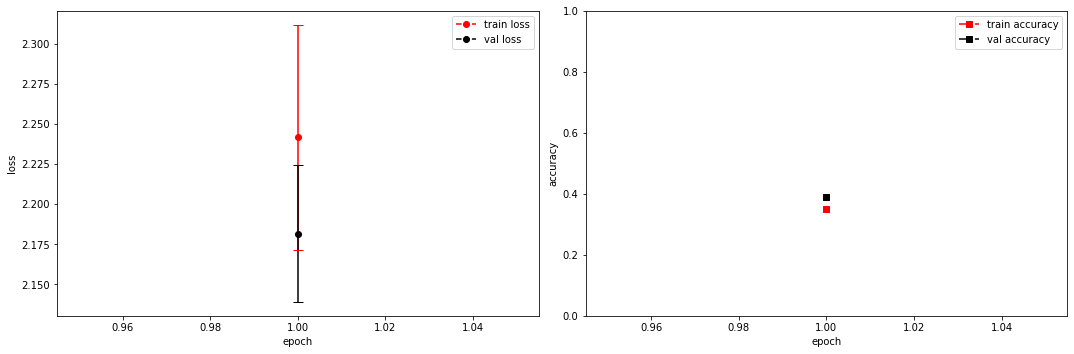

validation loss hist:  [2.1815621739342097]
model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 2.0685 +/- 0.0000,  accuracy: 0.03515625, time elapsed = 0.2953298091888428s
Epoch [2/100], step [17/84],  Loss: 2.1128 +/- 0.0412,  accuracy: 0.4814453125, time elapsed = 1.1844217777252197s
Epoch [2/100], step [33/84],  Loss: 2.0957 +/- 0.0568,  accuracy: 0.4853515625, time elapsed = 1.196845531463623s
Epoch [2/100], step [49/84],  Loss: 2.0794 +/- 0.0504,  accuracy: 0.490234375, time elapsed = 1.1836717128753662s
Epoch [2/100], step [65/84],  Loss: 2.0668 +/- 0.0467,  accuracy: 0.515625, time elapsed = 1.2213926315307617s
Epoch [2/100], step [81/84],  Loss: 2.0919 +/- 0.0444,  accuracy: 0.4775390625, time elapsed = 1.1792597770690918s
model set to eval

EPOCH FINISHED: ,  training acc = 0.4894648517620735,  val acc = 0.4571215510812826,  time elapsed = 8.293608665466309s


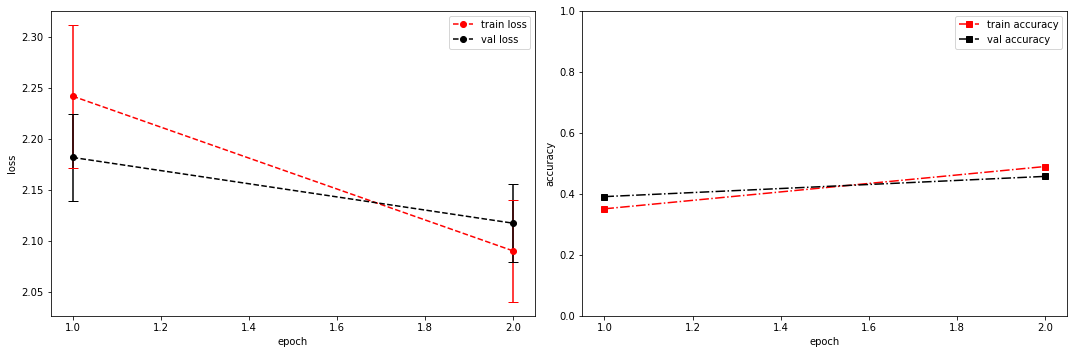

validation loss hist:  [2.1815621739342097, 2.1169683933258057]
model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 2.1226 +/- 0.0000,  accuracy: 0.0302734375, time elapsed = 0.29010009765625s
Epoch [3/100], step [17/84],  Loss: 1.9897 +/- 0.0506,  accuracy: 0.5986328125, time elapsed = 1.17362380027771s
Epoch [3/100], step [33/84],  Loss: 1.9936 +/- 0.0568,  accuracy: 0.5849609375, time elapsed = 1.172717809677124s
Epoch [3/100], step [49/84],  Loss: 1.9921 +/- 0.0479,  accuracy: 0.5986328125, time elapsed = 1.2108428478240967s
Epoch [3/100], step [65/84],  Loss: 1.9838 +/- 0.0444,  accuracy: 0.5947265625, time elapsed = 1.2228124141693115s
Epoch [3/100], step [81/84],  Loss: 1.9858 +/- 0.0437,  accuracy: 0.603515625, time elapsed = 1.1664726734161377s
model set to eval

EPOCH FINISHED: ,  training acc = 0.5944434085399962,  val acc = 0.4235645041014168,  time elapsed = 8.324398517608643s


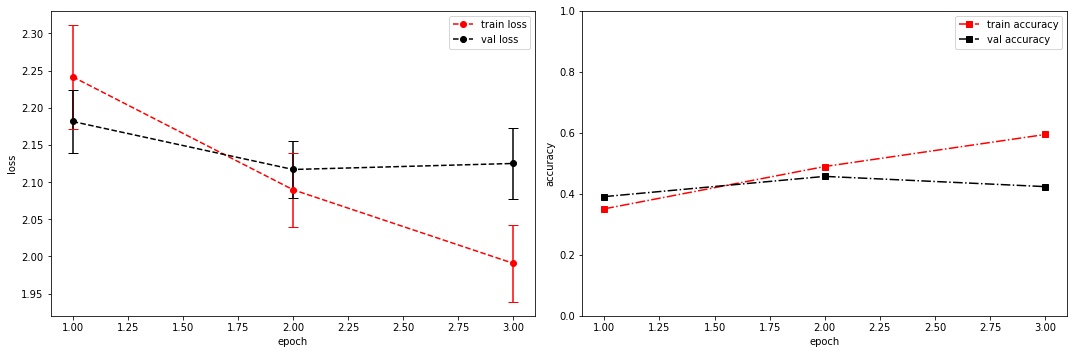

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593]
model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.9672 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.2953529357910156s
Epoch [4/100], step [17/84],  Loss: 1.9034 +/- 0.0373,  accuracy: 0.6806640625, time elapsed = 1.1954596042633057s
Epoch [4/100], step [33/84],  Loss: 1.9367 +/- 0.0342,  accuracy: 0.6455078125, time elapsed = 1.2246830463409424s
Epoch [4/100], step [49/84],  Loss: 1.9347 +/- 0.0503,  accuracy: 0.64453125, time elapsed = 1.239898920059204s
Epoch [4/100], step [65/84],  Loss: 1.9443 +/- 0.0490,  accuracy: 0.630859375, time elapsed = 1.2199971675872803s
Epoch [4/100], step [81/84],  Loss: 1.9283 +/- 0.0388,  accuracy: 0.650390625, time elapsed = 1.1854794025421143s
model set to eval

EPOCH FINISHED: ,  training acc = 0.6492634719373485,  val acc = 0.46234153616703955,  time elapsed = 8.37888479232788s


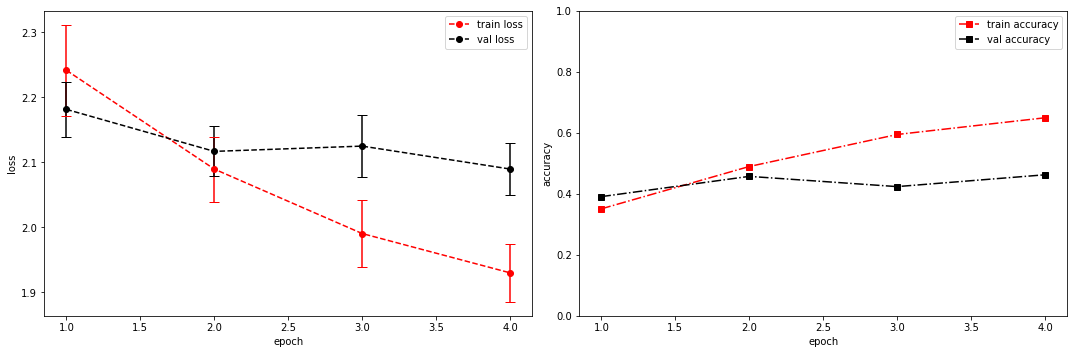

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315]
model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.8459 +/- 0.0000,  accuracy: 0.04296875, time elapsed = 0.2925591468811035s
Epoch [5/100], step [17/84],  Loss: 1.8365 +/- 0.0388,  accuracy: 0.740234375, time elapsed = 1.1870741844177246s
Epoch [5/100], step [33/84],  Loss: 1.8495 +/- 0.0352,  accuracy: 0.724609375, time elapsed = 1.19179105758667s
Epoch [5/100], step [49/84],  Loss: 1.8383 +/- 0.0421,  accuracy: 0.7333984375, time elapsed = 1.1874117851257324s
Epoch [5/100], step [65/84],  Loss: 1.8227 +/- 0.0535,  accuracy: 0.75390625, time elapsed = 1.2192280292510986s
Epoch [5/100], step [81/84],  Loss: 1.8560 +/- 0.0366,  accuracy: 0.7158203125, time elapsed = 1.1632628440856934s
model set to eval

EPOCH FINISHED: ,  training acc = 0.7333581950400895,  val acc = 0.4697986577181208,  time elapsed = 8.27539849281311s


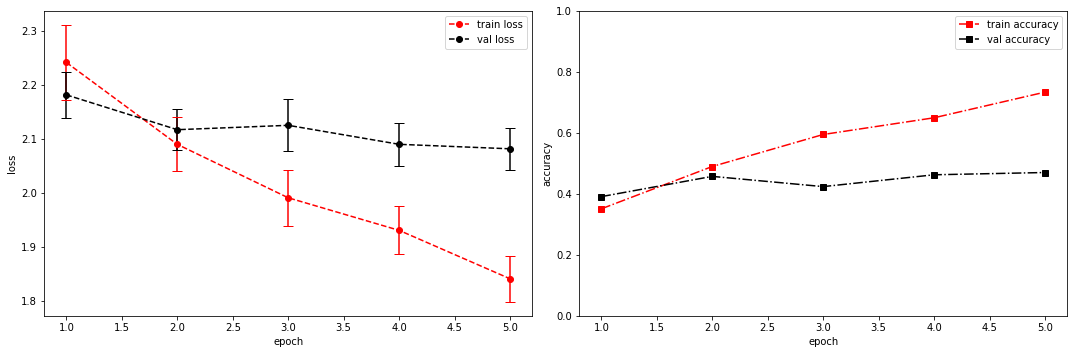

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741]
model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.7684 +/- 0.0000,  accuracy: 0.0498046875, time elapsed = 0.2858235836029053s
Epoch [6/100], step [17/84],  Loss: 1.7733 +/- 0.0486,  accuracy: 0.7890625, time elapsed = 1.1788451671600342s
Epoch [6/100], step [33/84],  Loss: 1.7749 +/- 0.0528,  accuracy: 0.7861328125, time elapsed = 1.1979568004608154s
Epoch [6/100], step [49/84],  Loss: 1.7798 +/- 0.0415,  accuracy: 0.7900390625, time elapsed = 1.1832268238067627s
Epoch [6/100], step [65/84],  Loss: 1.7743 +/- 0.0543,  accuracy: 0.7841796875, time elapsed = 1.2286765575408936s
Epoch [6/100], step [81/84],  Loss: 1.7815 +/- 0.0520,  accuracy: 0.7861328125, time elapsed = 1.1710219383239746s
model set to eval

EPOCH FINISHED: ,  training acc = 0.7874324072347567,  val acc = 0.46234153616703955,  time elapsed = 8.273112773895264s


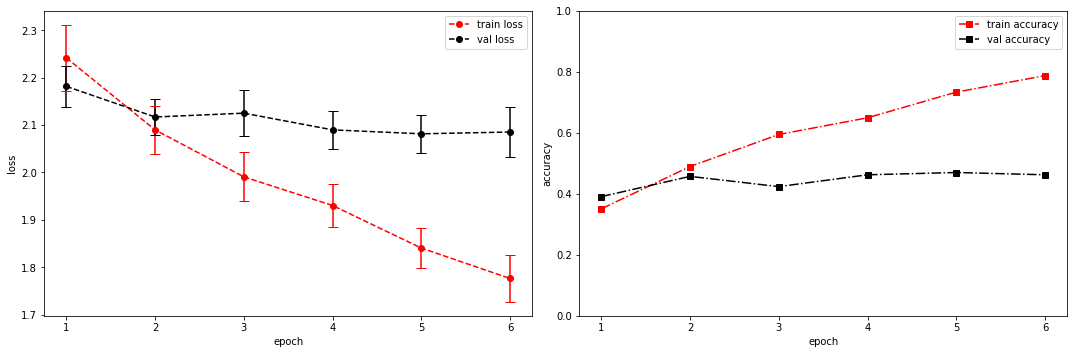

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992]
model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.6936 +/- 0.0000,  accuracy: 0.0556640625, time elapsed = 0.28768086433410645s
Epoch [7/100], step [17/84],  Loss: 1.7221 +/- 0.0460,  accuracy: 0.84375, time elapsed = 1.1909456253051758s
Epoch [7/100], step [33/84],  Loss: 1.7192 +/- 0.0346,  accuracy: 0.8408203125, time elapsed = 1.1812644004821777s
Epoch [7/100], step [49/84],  Loss: 1.7310 +/- 0.0389,  accuracy: 0.830078125, time elapsed = 1.1989171504974365s
Epoch [7/100], step [65/84],  Loss: 1.7192 +/- 0.0332,  accuracy: 0.845703125, time elapsed = 1.2195179462432861s
Epoch [7/100], step [81/84],  Loss: 1.7469 +/- 0.0346,  accuracy: 0.8134765625, time elapsed = 1.2272543907165527s
model set to eval

EPOCH FINISHED: ,  training acc = 0.8351668842066008,  val acc = 0.4429530201342282,  time elapsed = 8.3

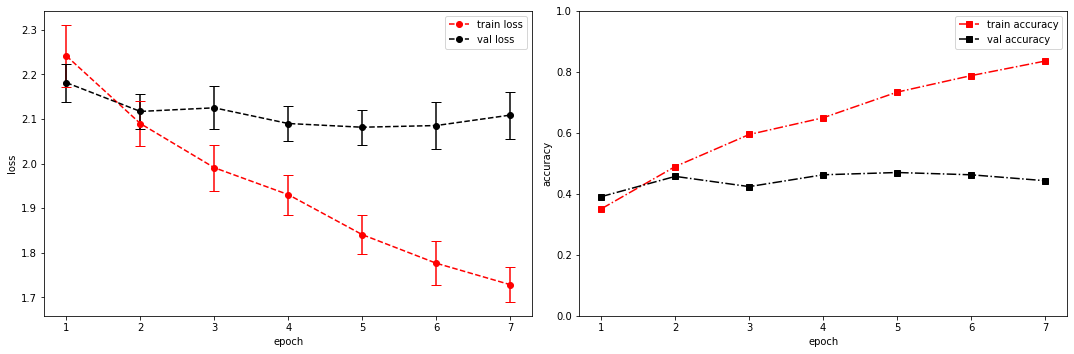

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296]
model saved


training epoch:  7
model set to train
Epoch [8/100], step [1/84],  Loss: 1.8711 +/- 0.0000,  accuracy: 0.0419921875, time elapsed = 0.2968928813934326s
Epoch [8/100], step [17/84],  Loss: 1.6931 +/- 0.0406,  accuracy: 0.8681640625, time elapsed = 1.174546718597412s
Epoch [8/100], step [33/84],  Loss: 1.7033 +/- 0.0317,  accuracy: 0.8583984375, time elapsed = 1.1741554737091064s
Epoch [8/100], step [49/84],  Loss: 1.6992 +/- 0.0340,  accuracy: 0.859375, time elapsed = 1.1839494705200195s
Epoch [8/100], step [65/84],  Loss: 1.6962 +/- 0.0387,  accuracy: 0.8642578125, time elapsed = 1.21439790725708s
Epoch [8/100], step [81/84],  Loss: 1.6964 +/- 0.0450,  accuracy: 0.8642578125, time elapsed = 1.173957109451294s
model set to eval

EPOCH FINISHED: ,  training acc = 0.860525825097893,  val acc = 0.4720357941834452,  t

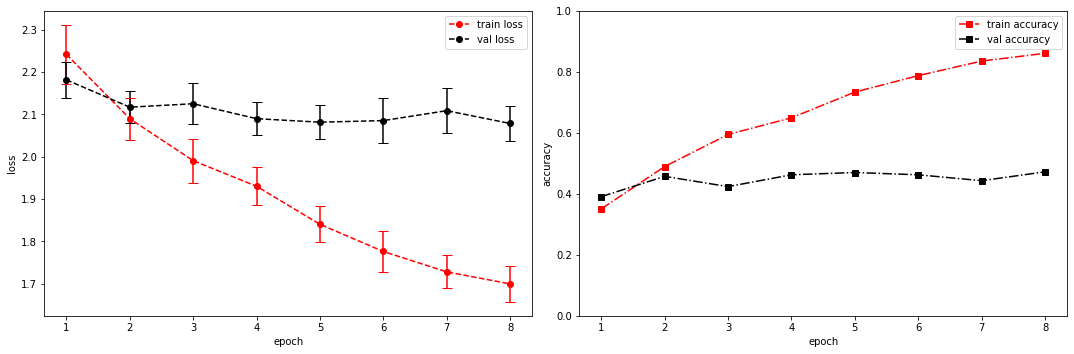

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655]
model saved


training epoch:  8
model set to train
Epoch [9/100], step [1/84],  Loss: 1.6654 +/- 0.0000,  accuracy: 0.0546875, time elapsed = 0.3060181140899658s
Epoch [9/100], step [17/84],  Loss: 1.6711 +/- 0.0320,  accuracy: 0.8828125, time elapsed = 1.1845893859863281s
Epoch [9/100], step [33/84],  Loss: 1.6932 +/- 0.0241,  accuracy: 0.8623046875, time elapsed = 1.175389051437378s
Epoch [9/100], step [49/84],  Loss: 1.6709 +/- 0.0493,  accuracy: 0.8896484375, time elapsed = 1.1853492259979248s
Epoch [9/100], step [65/84],  Loss: 1.6688 +/- 0.0378,  accuracy: 0.888671875, time elapsed = 1.2154557704925537s
Epoch [9/100], step [81/84],  Loss: 1.6817 +/- 0.0293,  accuracy: 0.875, time elapsed = 1.201002597808838s
model set to eval

EPOCH FINISHED: ,  training acc = 0.8795450307663621,  val acc = 0.4683072

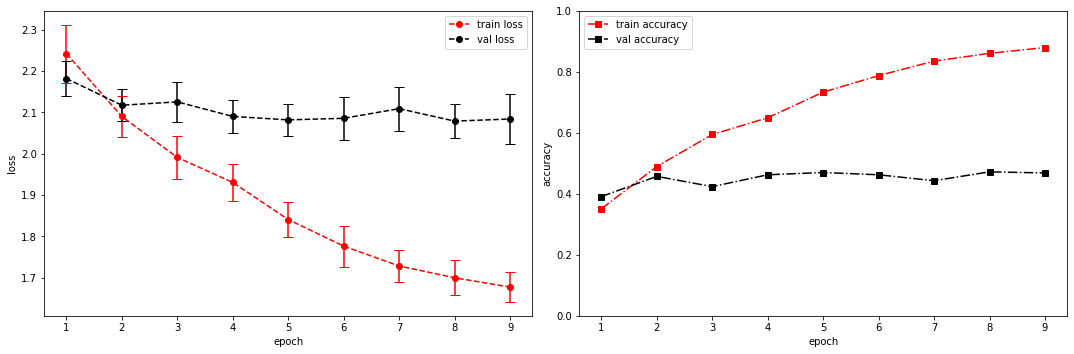

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627]
model saved


training epoch:  9
model set to train
Epoch [10/100], step [1/84],  Loss: 1.6350 +/- 0.0000,  accuracy: 0.0576171875, time elapsed = 0.30193161964416504s
Epoch [10/100], step [17/84],  Loss: 1.6436 +/- 0.0432,  accuracy: 0.908203125, time elapsed = 1.1764311790466309s
Epoch [10/100], step [33/84],  Loss: 1.6562 +/- 0.0369,  accuracy: 0.896484375, time elapsed = 1.2106969356536865s
Epoch [10/100], step [49/84],  Loss: 1.6532 +/- 0.0330,  accuracy: 0.9033203125, time elapsed = 1.173828363418579s
Epoch [10/100], step [65/84],  Loss: 1.6627 +/- 0.0391,  accuracy: 0.890625, time elapsed = 1.228400468826294s
Epoch [10/100], step [81/84],  Loss: 1.6532 +/- 0.0333,  accuracy: 0.900390625, time elapsed = 1.1714160442352295s
model set to eval

EPOCH FINISHED: ,  training acc = 0.8993

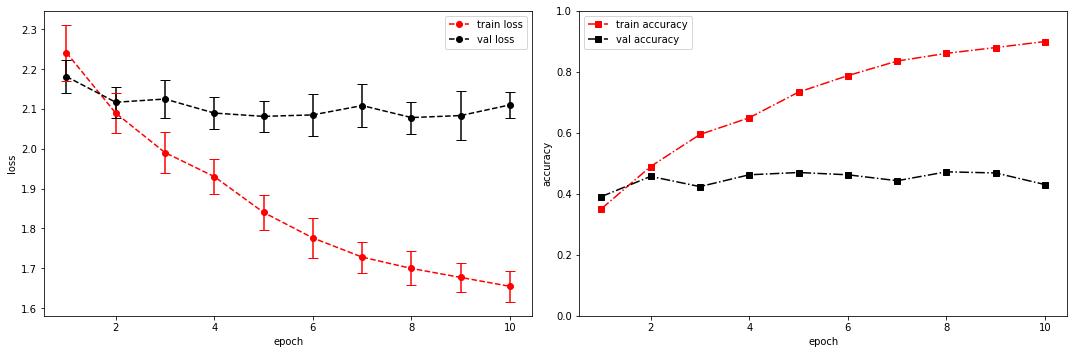

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365]
model saved


training epoch:  10
model set to train
Epoch [11/100], step [1/84],  Loss: 1.6348 +/- 0.0000,  accuracy: 0.0576171875, time elapsed = 0.314525842666626s
Epoch [11/100], step [17/84],  Loss: 1.6538 +/- 0.0316,  accuracy: 0.8984375, time elapsed = 1.211254358291626s
Epoch [11/100], step [33/84],  Loss: 1.6377 +/- 0.0351,  accuracy: 0.9169921875, time elapsed = 1.2120411396026611s
Epoch [11/100], step [49/84],  Loss: 1.6393 +/- 0.0296,  accuracy: 0.9150390625, time elapsed = 1.1999537944793701s
Epoch [11/100], step [65/84],  Loss: 1.6492 +/- 0.0341,  accuracy: 0.904296875, time elapsed = 1.2217693328857422s
Epoch [11/100], step [81/84],  Loss: 1.6594 +/- 0.0299,  accuracy: 0.89453125, time elapsed = 1.1742563247680664s
model set to eval

EPOCH FINISHED: ,  tra

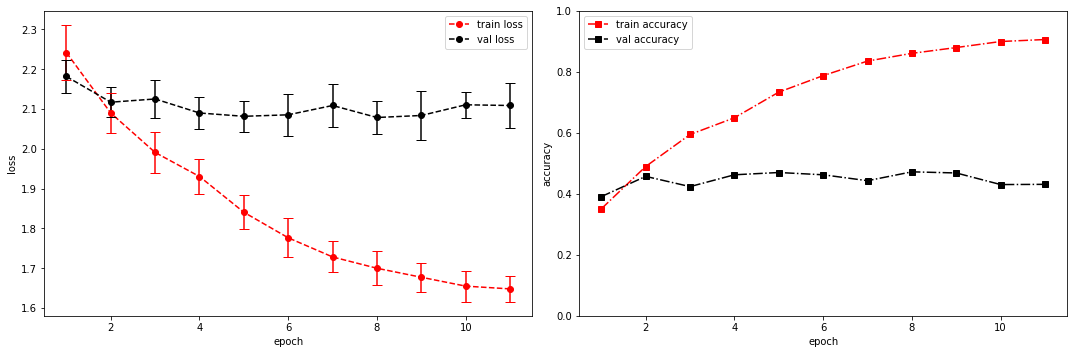

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504]
model saved


training epoch:  11
model set to train
Epoch [12/100], step [1/84],  Loss: 1.6398 +/- 0.0000,  accuracy: 0.0576171875, time elapsed = 0.29456019401550293s
Epoch [12/100], step [17/84],  Loss: 1.6371 +/- 0.0304,  accuracy: 0.9189453125, time elapsed = 1.2165231704711914s
Epoch [12/100], step [33/84],  Loss: 1.6297 +/- 0.0302,  accuracy: 0.921875, time elapsed = 1.1825954914093018s
Epoch [12/100], step [49/84],  Loss: 1.6297 +/- 0.0203,  accuracy: 0.9208984375, time elapsed = 1.189795970916748s
Epoch [12/100], step [65/84],  Loss: 1.6299 +/- 0.0314,  accuracy: 0.919921875, time elapsed = 1.2101035118103027s
Epoch [12/100], step [81/84],  Loss: 1.6362 +/- 0.0318,  accuracy: 0.9169921875, time elapsed = 1.1777360439300537s
model set to eval


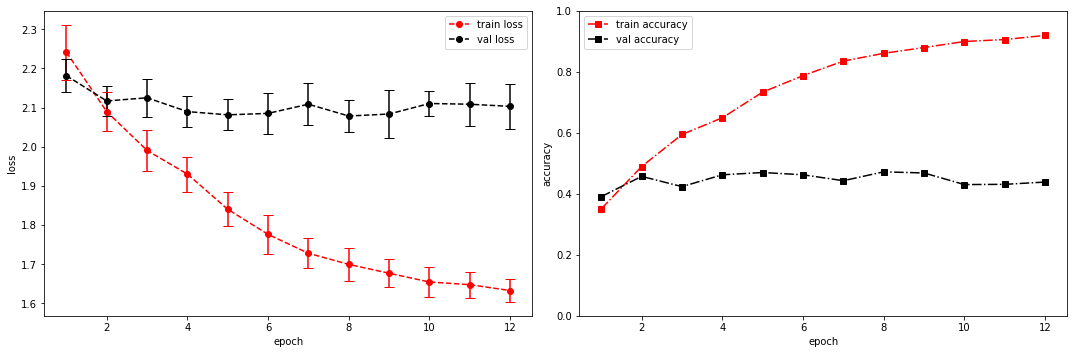

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327]
model saved


training epoch:  12
model set to train
Epoch [13/100], step [1/84],  Loss: 1.6016 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.30296754837036133s
Epoch [13/100], step [17/84],  Loss: 1.6333 +/- 0.0253,  accuracy: 0.9169921875, time elapsed = 1.1900546550750732s
Epoch [13/100], step [33/84],  Loss: 1.6311 +/- 0.0322,  accuracy: 0.9208984375, time elapsed = 1.2061429023742676s
Epoch [13/100], step [49/84],  Loss: 1.6171 +/- 0.0309,  accuracy: 0.931640625, time elapsed = 1.2046942710876465s
Epoch [13/100], step [65/84],  Loss: 1.6252 +/- 0.0324,  accuracy: 0.92578125, time elapsed = 1.2245688438415527s
Epoch [13/100], step [81/84],  Loss: 1.6200 +/- 0.0316,  accuracy: 0.9306640625, time elapsed = 1.162278890609741

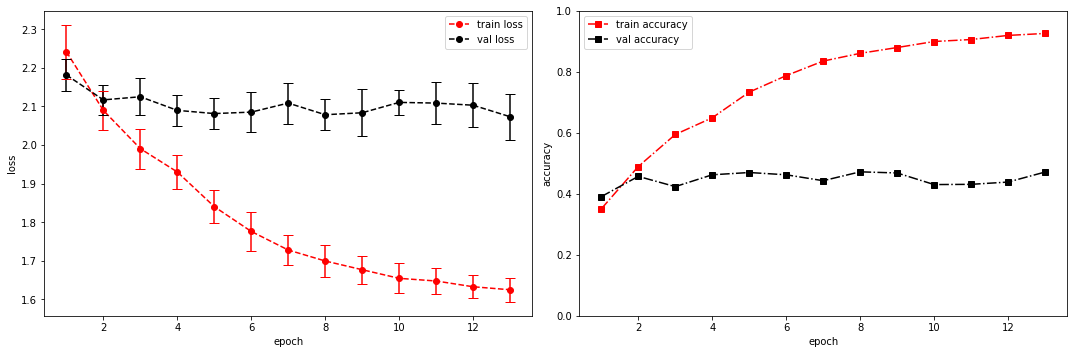

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939]
model saved


training epoch:  13
model set to train
Epoch [14/100], step [1/84],  Loss: 1.6438 +/- 0.0000,  accuracy: 0.056640625, time elapsed = 0.3188953399658203s
Epoch [14/100], step [17/84],  Loss: 1.6137 +/- 0.0184,  accuracy: 0.9375, time elapsed = 1.197709321975708s
Epoch [14/100], step [33/84],  Loss: 1.6145 +/- 0.0259,  accuracy: 0.93359375, time elapsed = 1.1950173377990723s
Epoch [14/100], step [49/84],  Loss: 1.6194 +/- 0.0205,  accuracy: 0.9326171875, time elapsed = 1.2022294998168945s
Epoch [14/100], step [65/84],  Loss: 1.6079 +/- 0.0241,  accuracy: 0.943359375, time elapsed = 1.2178316116333008s
Epoch [14/100], step [81/84],  Loss: 1.6172 +/- 0.0244,  accuracy: 0.93359375, time elapsed = 1.176862

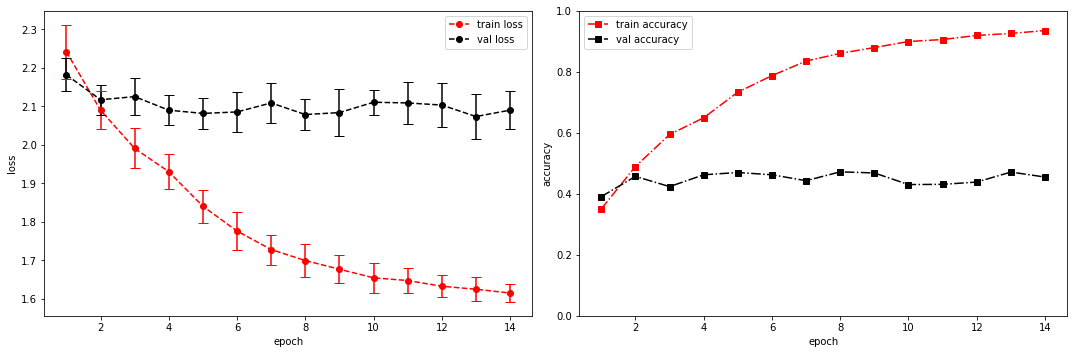

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647]
model saved


training epoch:  14
model set to train
Epoch [15/100], step [1/84],  Loss: 1.6711 +/- 0.0000,  accuracy: 0.0546875, time elapsed = 0.3222362995147705s
Epoch [15/100], step [17/84],  Loss: 1.6102 +/- 0.0393,  accuracy: 0.939453125, time elapsed = 1.2898149490356445s
Epoch [15/100], step [33/84],  Loss: 1.6086 +/- 0.0361,  accuracy: 0.9423828125, time elapsed = 1.1814520359039307s
Epoch [15/100], step [49/84],  Loss: 1.6203 +/- 0.0307,  accuracy: 0.9306640625, time elapsed = 1.1815662384033203s
Epoch [15/100], step [65/84],  Loss: 1.6085 +/- 0.0297,  accuracy: 0.943359375, time elapsed = 1.241562843322754s
Epoch [15/100], step [81/84],  Loss: 1.6026 +/- 0.0142,  accuracy: 0.94726562

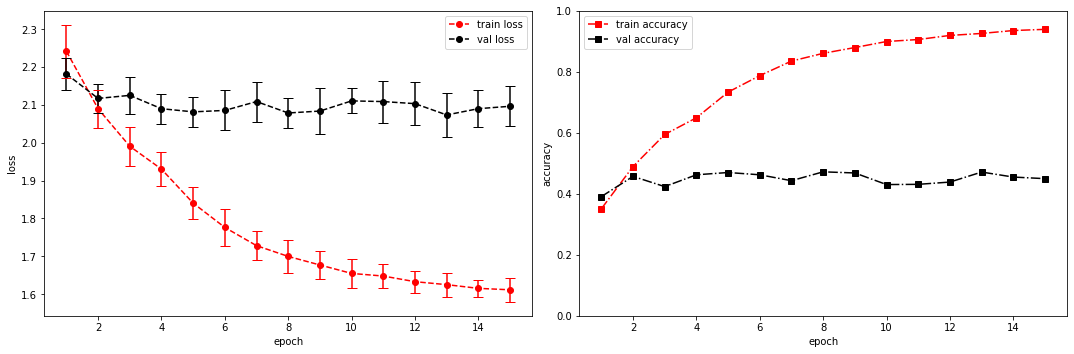

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517]
model saved


training epoch:  15
model set to train
Epoch [16/100], step [1/84],  Loss: 1.6112 +/- 0.0000,  accuracy: 0.05859375, time elapsed = 0.3018972873687744s
Epoch [16/100], step [17/84],  Loss: 1.5975 +/- 0.0182,  accuracy: 0.9521484375, time elapsed = 1.1914536952972412s
Epoch [16/100], step [33/84],  Loss: 1.6156 +/- 0.0329,  accuracy: 0.9345703125, time elapsed = 1.1848373413085938s
Epoch [16/100], step [49/84],  Loss: 1.6017 +/- 0.0281,  accuracy: 0.94921875, time elapsed = 1.214604377746582s
Epoch [16/100], step [65/84],  Loss: 1.6091 +/- 0.0272,  accuracy: 0.94140625, time elapsed = 1.2461364269256592s
Epoch [16/100], step [81/84],  Loss: 1.6169 +/- 0.0357,  a

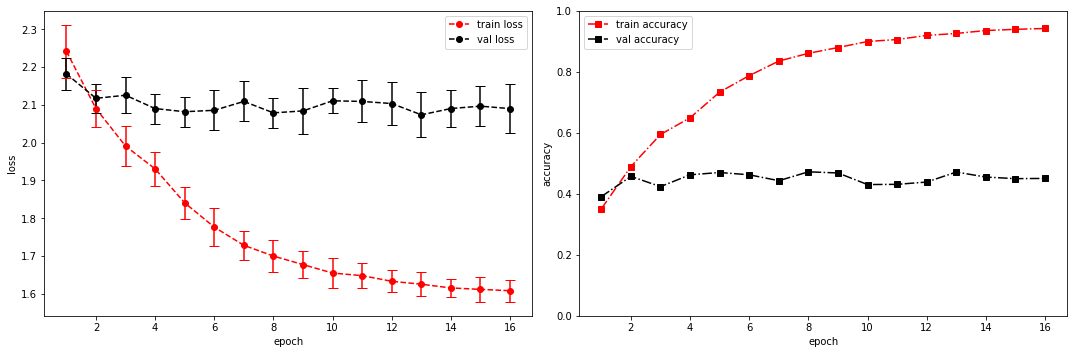

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183]
model saved


training epoch:  16
model set to train
Epoch [17/100], step [1/84],  Loss: 1.5878 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.30889058113098145s
Epoch [17/100], step [17/84],  Loss: 1.5916 +/- 0.0268,  accuracy: 0.95703125, time elapsed = 1.172405481338501s
Epoch [17/100], step [33/84],  Loss: 1.6060 +/- 0.0300,  accuracy: 0.9404296875, time elapsed = 1.2018239498138428s
Epoch [17/100], step [49/84],  Loss: 1.6128 +/- 0.0269,  accuracy: 0.9365234375, time elapsed = 1.1794698238372803s
Epoch [17/100], step [65/84],  Loss: 1.5984 +/- 0.0267,  accuracy: 0.9501953125, time elapsed = 1.223940372467041s
Epoch [17/100], step [81/84],  Loss

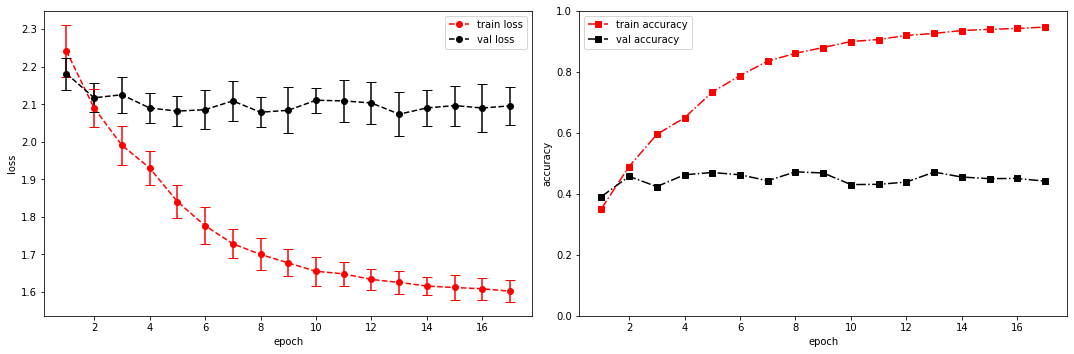

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288]
model saved


training epoch:  17
model set to train
Epoch [18/100], step [1/84],  Loss: 1.5791 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.2951347827911377s
Epoch [18/100], step [17/84],  Loss: 1.5910 +/- 0.0215,  accuracy: 0.95703125, time elapsed = 1.2021749019622803s
Epoch [18/100], step [33/84],  Loss: 1.6024 +/- 0.0250,  accuracy: 0.9453125, time elapsed = 1.1894822120666504s
Epoch [18/100], step [49/84],  Loss: 1.5918 +/- 0.0264,  accuracy: 0.955078125, time elapsed = 1.1803772449493408s
Epoch [18/100], step [65/84],  Loss: 1.6109 +/- 0.0291,  accuracy: 0.9384765625, time elapsed = 1.1883511543273926s
Epoch [18/100], st

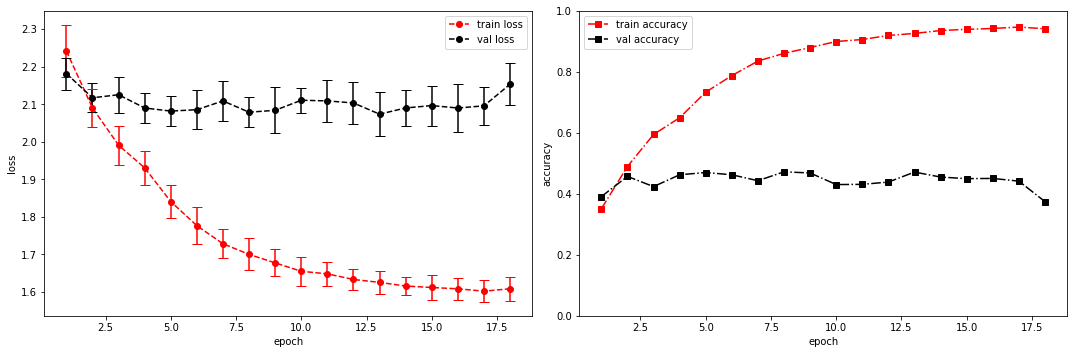

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453]
model saved


training epoch:  18
model set to train
Epoch [19/100], step [1/84],  Loss: 1.5971 +/- 0.0000,  accuracy: 0.0595703125, time elapsed = 0.30849123001098633s
Epoch [19/100], step [17/84],  Loss: 1.6076 +/- 0.0279,  accuracy: 0.943359375, time elapsed = 1.1790485382080078s
Epoch [19/100], step [33/84],  Loss: 1.6084 +/- 0.0291,  accuracy: 0.943359375, time elapsed = 1.1924159526824951s
Epoch [19/100], step [49/84],  Loss: 1.6075 +/- 0.0312,  accuracy: 0.943359375, time elapsed = 1.1889572143554688s
Epoch [19/100], step [65/84],  Loss: 1.6037 +/- 0.0238,  accuracy: 0.94921875, time elapsed = 1.2193708419799

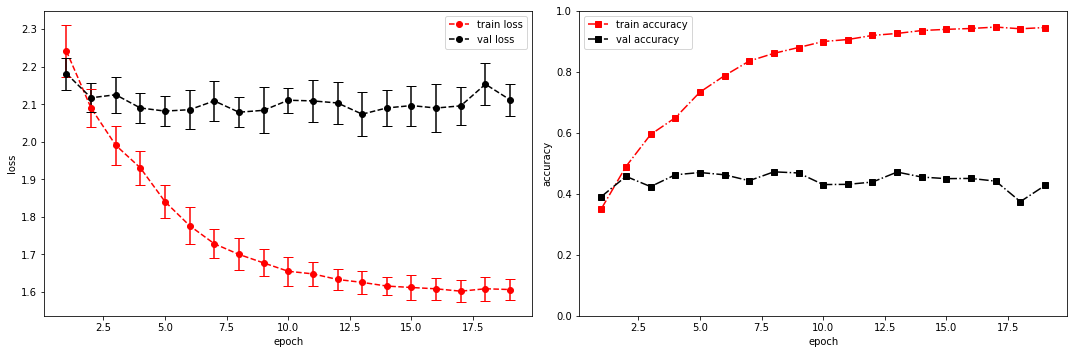

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473]
model saved


training epoch:  19
model set to train
Epoch [20/100], step [1/84],  Loss: 1.6151 +/- 0.0000,  accuracy: 0.05859375, time elapsed = 0.2978541851043701s
Epoch [20/100], step [17/84],  Loss: 1.6091 +/- 0.0277,  accuracy: 0.9404296875, time elapsed = 1.2083125114440918s
Epoch [20/100], step [33/84],  Loss: 1.5962 +/- 0.0272,  accuracy: 0.951171875, time elapsed = 1.1868443489074707s
Epoch [20/100], step [49/84],  Loss: 1.6055 +/- 0.0262,  accuracy: 0.9423828125, time elapsed = 1.185215950012207s
Epoch [20/100], step [65/84],  Loss: 1.6217 +/- 0.0183,  accuracy: 0.9306640625, time elapse

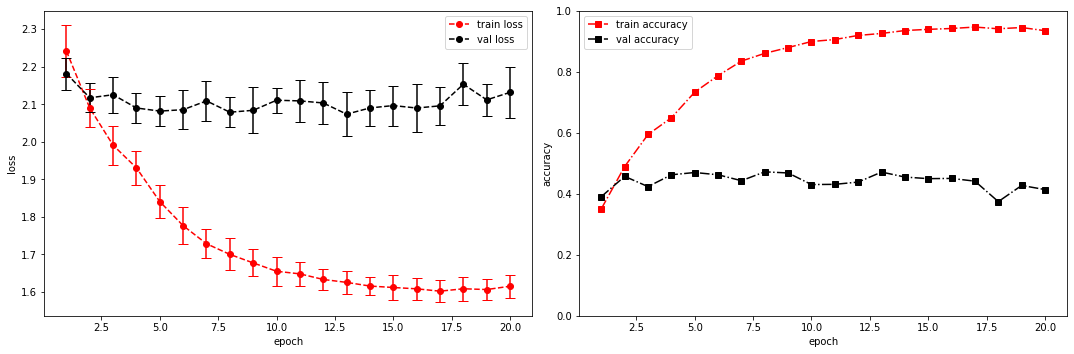

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467]
model saved


training epoch:  20
model set to train
Epoch [21/100], step [1/84],  Loss: 1.6276 +/- 0.0000,  accuracy: 0.0576171875, time elapsed = 0.2985072135925293s
Epoch [21/100], step [17/84],  Loss: 1.6107 +/- 0.0197,  accuracy: 0.9404296875, time elapsed = 1.2064239978790283s
Epoch [21/100], step [33/84],  Loss: 1.6040 +/- 0.0295,  accuracy: 0.9443359375, time elapsed = 1.2173552513122559s
Epoch [21/100], step [49/84],  Loss: 1.6149 +/- 0.0221,  accuracy: 0.935546875, time elapsed = 1.2033941745758057s
Epoch [21/100], step [65/84],  Loss: 1.6122 +/- 0.0215,  accuracy: 0.9

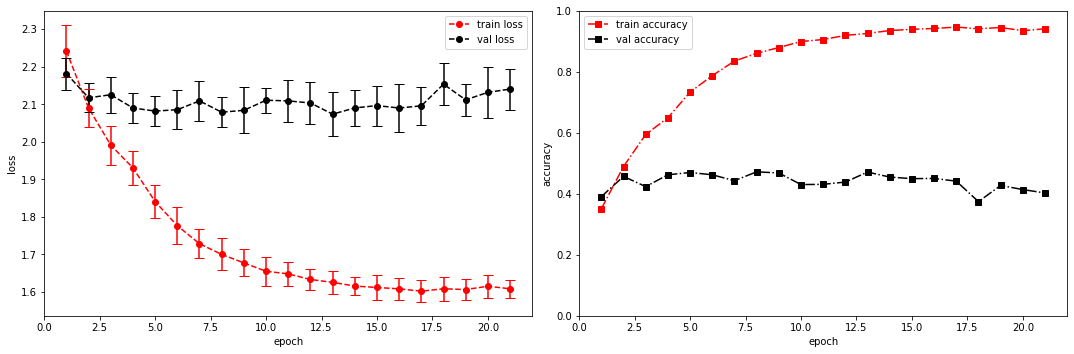

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467, 2.140132745107015]
model saved


training epoch:  21
model set to train
Epoch [22/100], step [1/84],  Loss: 1.5913 +/- 0.0000,  accuracy: 0.0595703125, time elapsed = 0.30162620544433594s
Epoch [22/100], step [17/84],  Loss: 1.5977 +/- 0.0286,  accuracy: 0.9501953125, time elapsed = 1.2638421058654785s
Epoch [22/100], step [33/84],  Loss: 1.6007 +/- 0.0245,  accuracy: 0.9501953125, time elapsed = 1.2293009757995605s
Epoch [22/100], step [49/84],  Loss: 1.6013 +/- 0.0261,  accuracy: 0.9462890625, time elapsed = 1.2568278312683105s
Epoch [22/100], step [65/84],  Loss: 1.5987 +/- 0

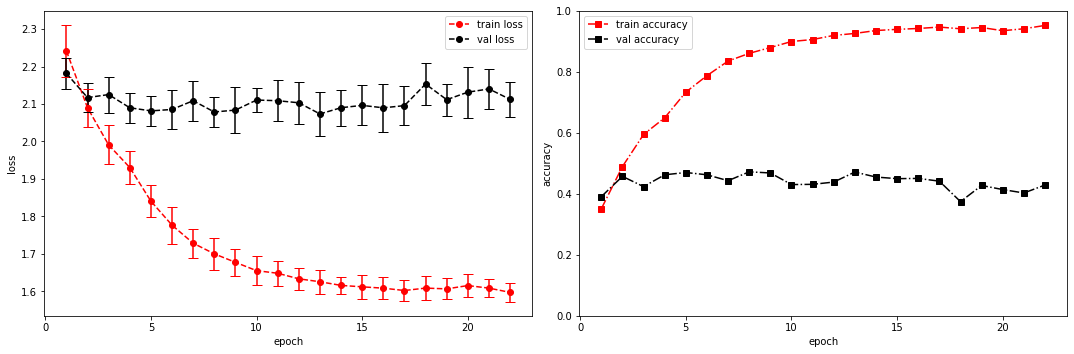

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467, 2.140132745107015, 2.1123098078228177]
model saved


training epoch:  22
model set to train
Epoch [23/100], step [1/84],  Loss: 1.5755 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.2980780601501465s
Epoch [23/100], step [17/84],  Loss: 1.5912 +/- 0.0213,  accuracy: 0.95703125, time elapsed = 1.1856296062469482s
Epoch [23/100], step [33/84],  Loss: 1.5915 +/- 0.0317,  accuracy: 0.955078125, time elapsed = 1.1880624294281006s
Epoch [23/100], step [49/84],  Loss: 1.6011 +/- 0.0198,  accuracy: 0.9482421875, time elapsed = 1.2005648612976074s
Epoch [23/100], step [65/84],  Los

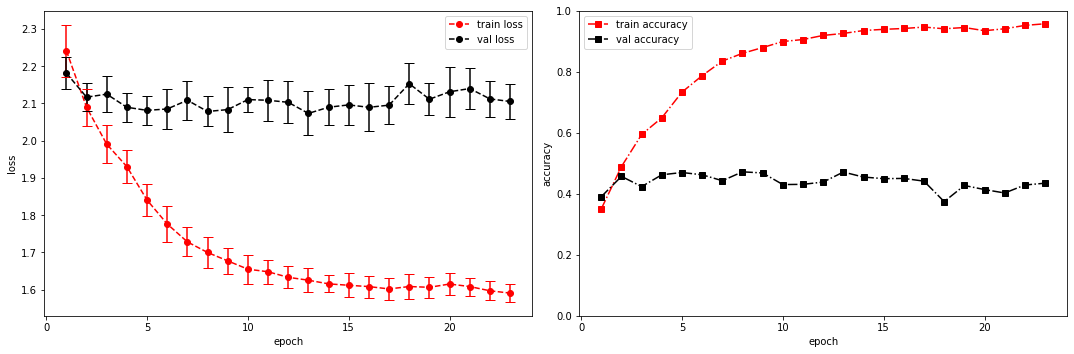

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467, 2.140132745107015, 2.1123098078228177, 2.105381965637207]
model saved


training epoch:  23
model set to train
Epoch [24/100], step [1/84],  Loss: 1.5806 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.3517742156982422s
Epoch [24/100], step [17/84],  Loss: 1.5764 +/- 0.0206,  accuracy: 0.96875, time elapsed = 1.1973700523376465s
Epoch [24/100], step [33/84],  Loss: 1.5870 +/- 0.0165,  accuracy: 0.95703125, time elapsed = 1.1714286804199219s
Epoch [24/100], step [49/84],  Loss: 1.5918 +/- 0.0227,  accuracy: 0.953125, time elapsed = 1.1772472858428955s
Epoch [24/100], step [6

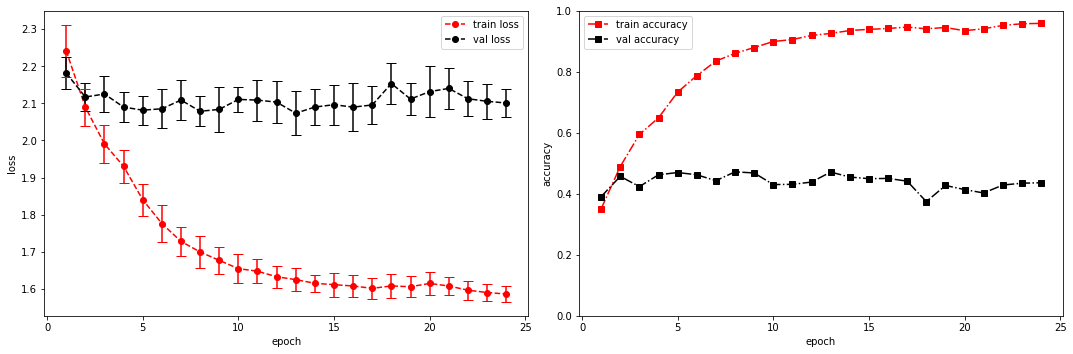

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467, 2.140132745107015, 2.1123098078228177, 2.105381965637207, 2.1008059637887135]
model saved


training epoch:  24
model set to train
Epoch [25/100], step [1/84],  Loss: 1.6416 +/- 0.0000,  accuracy: 0.056640625, time elapsed = 0.29945874214172363s
Epoch [25/100], step [17/84],  Loss: 1.5806 +/- 0.0298,  accuracy: 0.966796875, time elapsed = 1.1899161338806152s
Epoch [25/100], step [33/84],  Loss: 1.5867 +/- 0.0225,  accuracy: 0.9580078125, time elapsed = 1.2044768333435059s
Epoch [25/100], step [49/84],  Loss: 1.5829 +/- 0.0260,  accuracy: 0.9619140625, time elapsed = 1.1895551681

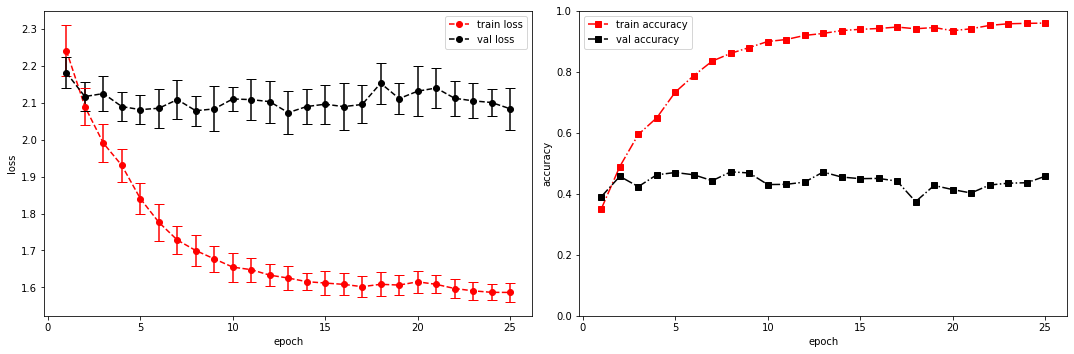

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467, 2.140132745107015, 2.1123098078228177, 2.105381965637207, 2.1008059637887135, 2.0839408295495168]
model saved


training epoch:  25
model set to train
Epoch [26/100], step [1/84],  Loss: 1.5595 +/- 0.0000,  accuracy: 0.0615234375, time elapsed = 0.29960036277770996s
Epoch [26/100], step [17/84],  Loss: 1.5779 +/- 0.0245,  accuracy: 0.9677734375, time elapsed = 1.260969638824463s
Epoch [26/100], step [33/84],  Loss: 1.5856 +/- 0.0295,  accuracy: 0.958984375, time elapsed = 1.2101545333862305s
Epoch [26/100], step [49/84],  Loss: 1.5784 +/- 0.0188,  accuracy: 0.96875, time elapsed

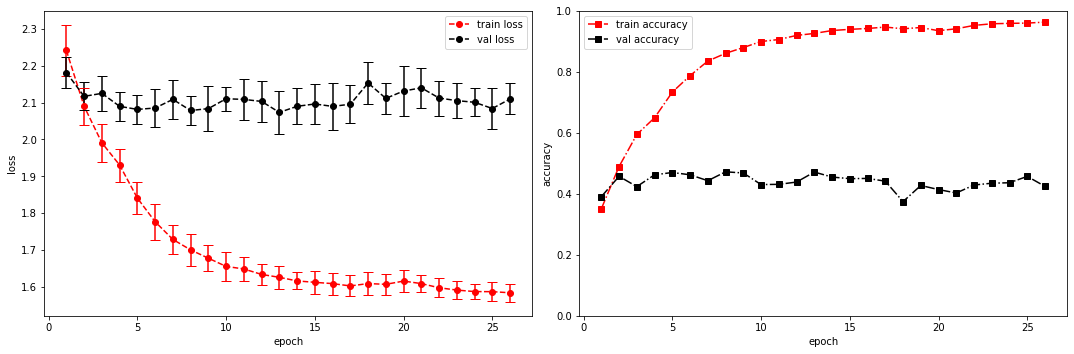

validation loss hist:  [2.1815621739342097, 2.1169683933258057, 2.125083741687593, 2.0898346446809315, 2.081513983862741, 2.0852754399889992, 2.1086840743110296, 2.0785231703803655, 2.0836102224531627, 2.1104584194365, 2.1086712848572504, 2.103151009196327, 2.073353165671939, 2.0899266742524647, 2.0962254206339517, 2.0896929502487183, 2.0955449796858288, 2.1531673045385453, 2.111474082583473, 2.131480750583467, 2.140132745107015, 2.1123098078228177, 2.105381965637207, 2.1008059637887135, 2.0839408295495168, 2.1098536480040777]
model saved


training epoch:  26
model set to train
Epoch [27/100], step [1/84],  Loss: 1.5811 +/- 0.0000,  accuracy: 0.060546875, time elapsed = 0.30871152877807617s
Epoch [27/100], step [17/84],  Loss: 1.5868 +/- 0.0275,  accuracy: 0.9599609375, time elapsed = 1.1824848651885986s
Epoch [27/100], step [33/84],  Loss: 1.5810 +/- 0.0232,  accuracy: 0.9658203125, time elapsed = 1.1865684986114502s


KeyboardInterrupt: ignored

In [ ]:
from textwrap import dedent
notes = dedent("""
  Initial test of CNN implemented in models.ipynb of notebooks folder on drive.

  Using CrossEntropyLoss
""")

args_dict = {
    #'filename': 'irmas_data_mfcc13_hop_length256_n_fft2048.json',
    'filename': 'irmas_data_mfcc40_hop_length512_n_fft2048.json',
    'model_id': "CNN_1",
    'num_epochs': 100,
    'interval': 16,
    'lr': 0.001,
    'batch_size': 64,
    'val_split': 0.2,
    'save_checkpoint': True,
    'checkpoint_path': '/content/drive/MyDrive/ITCS 5156 project/trained_models/',
    'checkpoint_name': 'testing_CNN_1.pt',
    'notes': notes,
    'criterion': torch.nn.CrossEntropyLoss(),
    'patience': 2,
    'min_epochs': 1,
    'buffer': 0.5
}

train_model(**args_dict)

# Loop through json files

In [ ]:

files = os.listdir(JSON_PATH)
files[:-1]

['irmas_data_mfcc13_hop_length512_n_fft2048.json',
 'irmas_data_mfcc20_hop_length512_n_fft2048.json',
 'irmas_data_mfcc30_hop_length512_n_fft2048.json',
 'irmas_data_mfcc40_hop_length512_n_fft2048.json',
 'irmas_data_mfcc13_hop_length512_n_fft1024.json',
 'irmas_data_mfcc13_hop_length512_n_fft4096.json',
 'irmas_data_mfcc13_hop_length256_n_fft2048.json',
 'irmas_data_mfcc13_hop_length1024_n_fft2048.json']

In [ ]:
mfcc = [13, 20, 30, 40, 13, 13, 13, 13]
hop_length = [512, 512, 512, 512, 512, 512, 256, 1024]
n_fft = [2048, 2048, 2048, 2048, 1024, 4096, 2048, 2048]

args_dict = {
    #'filename': 'irmas_data_mfcc13_hop_length256_n_fft2048.json',
    'model_id': 'CNN_1',
    'num_epochs': 100,
    'interval': 16,
    'lr': 0.0001,
    'batch_size': 64,
    'val_split': 0.2,
    'save_checkpoint': True,
    'checkpoint_path': '/content/drive/MyDrive/ITCS 5156 project/trained_models/',
    #'checkpoint_name': 'testing_CNN_1.pt',
    #'notes': notes,
    'criterion': torch.nn.CrossEntropyLoss(),
    'patience': 3,
    'min_epochs': 5,
    'buffer': 0.05,
}

for i, file in enumerate(os.listdir(JSON_PATH)[:-1]):
  print("file: {}; mfcc: {}; hop_length: {}; n_fft: {}".format(
      file, mfcc[i], hop_length[i], n_fft[i]
  ))

  args_dict['filename'] = file
  args_dict['checkpoint_name'] = "CNN_1_mfcc{}_hop_length{}_n_fft{}.pt".format(
      mfcc[i], hop_length[i], n_fft[i]
  )
  args_dict['notes'] = """
  CNN model initially defined in models.ipynb (pretty sure that was Nick's) ran on batch
  of different dataset hyperparams- varied # of mfccs, hop_length, and n_fft. Ran until
  early stop with minimum epochs = 5

  other hyperparams: 
  max_epochs=100
  interval=16
  lr=0.0001
  batch_size=64
  val_split=0.2
  criterion=CrossEntropyLoss
  dropout_probs = [0.2, 0.15]
  buffer = 0.05

  # mfccs = {}
  hop_length = {} 
  n_fft = {}
  """.format(mfcc[i], hop_length[i], n_fft[i])
  train_model(**args_dict)

Output hidden; open in https://colab.research.google.com to view.

# Try dropout_prob = 0.5

In [ ]:
mfcc = [13, 20, 30, 40, 13, 13, 13, 13]
hop_length = [512, 512, 512, 512, 512, 512, 256, 1024]
n_fft = [2048, 2048, 2048, 2048, 1024, 4096, 2048, 2048]

args_dict = {
    #'filename': 'irmas_data_mfcc13_hop_length256_n_fft2048.json',
    'model_id': 'CNN_1',
    'num_epochs': 100,
    'interval': 16,
    'lr': 0.0001,
    'batch_size': 64,
    'val_split': 0.2,
    'save_checkpoint': True,
    'checkpoint_path': '/content/drive/MyDrive/ITCS 5156 project/trained_models/',
    #'checkpoint_name': 'testing_CNN_1.pt',
    #'notes': notes,
    'criterion': torch.nn.CrossEntropyLoss(),
    'patience': 3,
    'min_epochs': 5,
    'buffer': 0.05,
}

for i, file in enumerate(os.listdir(JSON_PATH)[:-1]):
  print("file: {}; mfcc: {}; hop_length: {}; n_fft: {}".format(
      file, mfcc[i], hop_length[i], n_fft[i]
  ))
  args_dict['dropout_prob'] = [0.5, 0.25]
  args_dict['filename'] = file
  args_dict['checkpoint_name'] = "CNN_1_mfcc{}_hop_length{}_n_fft{}_drop05.pt".format(
      mfcc[i], hop_length[i], n_fft[i]
  )
  args_dict['notes'] = """
  CNN model initially defined in models.ipynb (pretty sure that was Nick's) ran on batch
  of different dataset hyperparams- varied # of mfccs, hop_length, and n_fft. Ran until
  early stop with minimum epochs = 5
  
  Increased dropout probabilities compared to original model

  other hyperparams: 
  max_epochs=100
  interval=16
  lr=0.0001
  batch_size=64
  val_split=0.2
  criterion=CrossEntropyLoss
  dropout_probs = [0.5, 0.25]
  buffer = 0.05

  # mfccs = {}
  hop_length = {} 
  n_fft = {}
  """.format(mfcc[i], hop_length[i], n_fft[i])
  train_model(**args_dict)

Output hidden; open in https://colab.research.google.com to view.